<a href="https://colab.research.google.com/github/rudyhendrawn/Riset-AI-SIKGM/blob/main/yamnet_transfer_learning_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Transfer learning with YAMNet for environmental sound classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), such as laughter, barking, or a siren. 

 In this tutorial you will learn how to:

- Load and use the YAMNet model for inference.
- Build a new model using the YAMNet embeddings to classify cat and dog sounds.
- Evaluate and export your model.


## Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [1]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 117.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

from IPython import display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

You will need a function to load audio files, which will also be used later when working with the training data. (Learn more about reading audio files and their labels in [Simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [4]:
# Utility functions for loading audio files and making sure the sample rate is correct.
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Bioakustik Gajah Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Use this if the dataset still in Zip format

Otherwise, skip it!

In [6]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/datasets/bioakustik-gajah'
# FILENAME = 'segmented_audio_data_v2.zip'

# from zipfile import ZipFile
  
# # loading the temp.zip and creating a zip object
# with ZipFile(os.path.join(DATA_DIR, FILENAME), 'r') as zObject:
#     zObject.extractall(path=DATA_DIR)
# zObject.close()

In [7]:
train_metadata = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
val_metadata = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
test_metadata = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
train_metadata.tail()

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id,alt_class,alt_class_id
1478,rumble_18.wav,rumble,22050,68782,1,16,PCM_S,2,rumble,2
1479,firecracker_64.wav,firecracker,22050,16777,1,16,PCM_S,17,other,1
1480,trumpet_137.wav,trumpet,22050,37587,1,16,PCM_S,0,trumpet,0
1481,roar_rumble_48.wav,roar_rumble,22050,55570,1,16,PCM_S,7,roar_rumble,4
1482,rumble_350.wav,rumble,22050,62646,1,16,PCM_S,2,rumble,2


In [8]:
print("Validation length: {}".format(len(val_metadata)))
print("Test length: {}".format(len(test_metadata)))

Validation length: 371
Test length: 206


In [9]:
# Give complete path to filename
train_metadata['filename'] = train_metadata['filename'].apply(lambda x: os.path.join(DATA_DIR, x))
val_metadata['filename'] = val_metadata['filename'].apply(lambda x: os.path.join(DATA_DIR, x))
test_metadata['filename'] = test_metadata['filename'].apply(lambda x: os.path.join(DATA_DIR, x))

# Use only filename and alt_class_id column in train, val, and test
train_df_filename = train_metadata['filename'].copy()
train_df_label = train_metadata['alt_class_id'].copy()

val_df_filename = val_metadata['filename'].copy()
val_df_label = val_metadata['alt_class_id'].copy()

test_df_filename = test_metadata['filename'].copy()
test_df_label = test_metadata['alt_class_id'].copy()

train_df_filename.head()

0    /content/drive/MyDrive/Colab Notebooks/dataset...
1    /content/drive/MyDrive/Colab Notebooks/dataset...
2    /content/drive/MyDrive/Colab Notebooks/dataset...
3    /content/drive/MyDrive/Colab Notebooks/dataset...
4    /content/drive/MyDrive/Colab Notebooks/dataset...
Name: filename, dtype: object

In [10]:
train_df_label.value_counts()

2    527
1    370
0    292
5    173
3     72
4     39
7      6
6      4
Name: alt_class_id, dtype: int64

### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df_filename, train_df_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_df_filename, val_df_label))
test_ds = tf.data.Dataset.from_tensor_slices((test_df_filename, test_df_label))
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [12]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

train_ds = train_ds.map(load_wav_for_map)
print(train_ds.element_spec)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [13]:
val_ds = val_ds.map(load_wav_for_map)
print(val_ds.element_spec)

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [14]:
test_ds = test_ds.map(load_wav_for_map)
print(test_ds.element_spec)

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [15]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings, tf.repeat(label, num_embeddings))

# extract embedding
train_ds = train_ds.map(extract_embedding).unbatch()
val_ds = val_ds.map(extract_embedding).unbatch()
test_ds = test_ds.map(extract_embedding).unbatch()
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


### Split the data
Use this if you don't split the dataframe in the first place.

In [ ]:
# # Shuffle the dataset
# cached_ds = main_ds.cache()
# # shuffled_ds = main_ds.shuffle(buffer_size=2060)

# # Determine the size of each split
# total_size = len(list(cached_ds))
# print(total_size)
# train_size = int(0.7 * total_size)
# val_size = int(0.2 * total_size)
# # test_size is the remaining elements

# # Split the data
# train_ds = cached_ds.take(train_size)
# val_ds = cached_ds.skip(train_size).take(val_size)
# test_ds = cached_ds.skip(train_size + val_size)

In [16]:
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [17]:
classes_name = list(train_metadata['alt_class'].unique())
yamnet_last_layer = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes_name))
], name='yamnet_last_layer')

yamnet_last_layer.summary()

Model: "yamnet_last_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 658,184
Trainable params: 658,184
Non-trainable params: 0
_________________________________________________________________


In [18]:
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Bioakustik-Gajah'
MODEL_CHECKPOINT_DIR = os.path.join(SAVE_DIR, 'model-checkpoint/')
MODEL_DIR = os.path.join(SAVE_DIR, 'model/')

In [19]:
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_DIR,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

yamnet_last_layer.save_weights(MODEL_CHECKPOINT_DIR.format(epoch=0))

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True)

callbacks = [lr_scheduler, earlystopping, model_checkpoint]


# initial_lr = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_lr,
#     decay_steps=500,
#     decay_rate=0.96,
#     staircase=True
# )
yamnet_last_layer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
tf.keras.backend.clear_session()
batch_size = 16
epochs = 30
validation_steps = len(val_df_filename) // batch_size
history = yamnet_last_layer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/30
489/489 [==============================] - 249s 454ms/step - loss: 1.6639 - accuracy: 0.7476 - val_loss: 1.0863 - val_accuracy: 0.6793 - lr: 0.0100
Epoch 2/30
489/489 [==============================] - 6s 12ms/step - loss: 1.6717 - accuracy: 0.7481 - val_loss: 1.0916 - val_accuracy: 0.6372 - lr: 0.0100
Epoch 3/30
489/489 [==============================] - 6s 12ms/step - loss: 0.8929 - accuracy: 0.7593 - val_loss: 0.9859 - val_accuracy: 0.6603 - lr: 0.0100
Epoch 4/30
489/489 [==============================] - 5s 11ms/step - loss: 0.6941 - accuracy: 0.7732 - val_loss: 0.9668 - val_accuracy: 0.6984 - lr: 0.0100
Epoch 5/30
489/489 [==============================] - 7s 14ms/step - loss: 0.8040 - accuracy: 0.7799 - val_loss: 1.0333 - val_accuracy: 0.6943 - lr: 0.0100
Epoch 6/30
489/489 [==============================] - 5s 11ms/step - loss: 0.6815 - accuracy: 0.7819 - val_loss: 0.9595 - val_accuracy: 0.7255 - lr: 0.0090
Epoch 7/30
489/489 [==============================] - 7s 14ms

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [21]:
loss, accuracy = yamnet_last_layer.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

70/70 [==============================] - 33s 447ms/step - loss: 0.7097 - accuracy: 0.7878
Loss:  0.709686815738678
Accuracy:  0.7878378629684448


### Measures Metrics

In [23]:
def get_metric_results(model, data_test: tf.data.Dataset.prefetch):
    prediction = model.predict(data_test)
    y_pred = np.argmax(prediction, axis=1)
    y_true = []
    for _, label in data_test:
        y_true.extend(label.numpy())
    y_true = np.array(y_true)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print("Accuracy: {}".format(acc))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1: {}".format(f1))

get_metric_results(yamnet_last_layer, test_ds)

70/70 [==============================] - 0s 2ms/step
Accuracy: 0.7878378378378378
Precision: 0.43224111216580247
Recall: 0.3222523654759963
F1: 0.3436724276363196


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [24]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [25]:
saved_model_path = os.path.join(DATA_DIR, MODEL_DIR)

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = yamnet_last_layer(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)

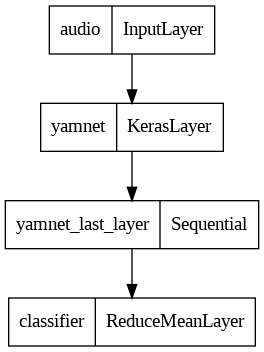

In [34]:
serving_model.save(saved_model_path, include_optimizer=True)
tf.keras.utils.plot_model(serving_model)

Load your saved model to verify that it works as expected.

In [35]:
reloaded_model = tf.saved_model.load(saved_model_path)

And for the final test: given some sound data, does your model return the correct result?

In [27]:
test_metadata[['filename', 'alt_class', 'alt_class_id']].sample(10)

,filename,alt_class,alt_class_id
9,/content/drive/MyDrive/Colab Notebooks/dataset...,other,1
88,/content/drive/MyDrive/Colab Notebooks/dataset...,roar,3
150,/content/drive/MyDrive/Colab Notebooks/dataset...,other,1
10,/content/drive/MyDrive/Colab Notebooks/dataset...,rumble,2
91,/content/drive/MyDrive/Colab Notebooks/dataset...,other,1
69,/content/drive/MyDrive/Colab Notebooks/dataset...,trumpet,0
110,/content/drive/MyDrive/Colab Notebooks/dataset...,trumpet,0
117,/content/drive/MyDrive/Colab Notebooks/dataset...,roar,3
147,/content/drive/MyDrive/Colab Notebooks/dataset...,other,1
75,/content/drive/MyDrive/Colab Notebooks/dataset...,rumble,2


In [30]:
testing_wav_data = load_wav_16k_mono(test_metadata['filename'][110])

reloaded_results = reloaded_model(testing_wav_data)
cls = tf.math.argmax(reloaded_results)
prediction_class = classes_name[cls]
prediction_prob = tf.nn.softmax(reloaded_results, axis=-1)
cls_prob = prediction_prob[cls]
print(f"The prediction sound is: {prediction_class}, confident value: {cls_prob}")

The prediction sound is: roar, confident value: 0.37774479389190674


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [31]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
pred_results = classes_name[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {pred_results}')

The main sound is: roar


## Convert Model to TF-Lite

In [37]:
model = tf.saved_model.load(export_dir=os.path.join(SAVE_DIR, 'model'))

In [39]:
testing_wav_data = load_wav_16k_mono(test_metadata['filename'][110])

reloaded_results = model(testing_wav_data)
cls = tf.math.argmax(reloaded_results)
classes_name = list(train_metadata['alt_class'].unique())
prediction_class = classes_name[cls]
prediction_prob = tf.nn.softmax(reloaded_results, axis=-1)
cls_prob = prediction_prob[cls]
print(f"The prediction sound is: {prediction_class}, confident value: {cls_prob}")

The prediction sound is: roar, confident value: 0.4141089618206024


In [40]:
# 1st Mechanism
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(SAVE_DIR, 'model')) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
# tflite_dir = os.path.join(SAVE_DIR, 'TFLite-model')
with open('model-v0.3.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Convert the model from the reloaded_model object
converter = tf.lite.TFLiteConverter.from_keras_model(yamnet_last_layer)
tflite_model = converter.convert()

with open('model-v0.3-from-keras-model-wo-rdm.tflite', 'wb') as f:
    f.write(tflite_model)